<h1><center>Assignment 9: AUTHOR CLASSIFICATION </center></h1>

## Preprocess data

In [194]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import backend as K

In [195]:
from nltk.corpus import gutenberg, words

print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [196]:
for fileid in gutenberg.fileids():
    print(len(gutenberg.words(fileid)), end=' ')

192427 98171 141576 1010654 8354 55563 18963 34110 96996 86063 69213 210663 260819 96825 25833 37360 23140 154883 

In [197]:
import re
authors, novels = [], []

# get the author's name and novel
for fileid in gutenberg.fileids():
    # get the author
    author = re.compile('(?P<before>.+)-').search(fileid).group('before')
    
    #get the novel
    novel = re.compile('-(?P<after>.+)').search(fileid).group('after')
    novel = novel.replace('.txt', '')
    
    authors.append(author)
    novels.append(novel)


In [198]:
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

list_word = []
for fileid in gutenberg.fileids():
    # convert to lower case 
    lower = [word.lower() for word in gutenberg.words(fileid)]
    
    # remove number and punctuation and stop words
    remove = [word for word in lower if word.isalpha() == True and word not in STOP_WORDS]
    
    list_word.append(remove)


In [199]:
for i in list_word:
    print(len(i), end=' ')

61007 32276 45383 335198 3657 19419 7034 11104 34986 31657 24934 70376 98827 41398 10474 14981 9565 61568 

In [200]:
df = pd.DataFrame(data={'Novels': novels, 'Texts': list_word, 'Authors': authors})
df

,Novels,Texts,Authors
0,emma,"[emma, jane, austen, volume, chapter, emma, wo...",austen
1,persuasion,"[persuasion, jane, austen, chapter, sir, walte...",austen
2,sense,"[sense, sensibility, jane, austen, chapter, fa...",austen
3,kjv,"[king, james, bible, old, testament, king, jam...",bible
4,poems,"[poems, william, blake, songs, innocence, expe...",blake
5,stories,"[stories, tell, children, sara, cone, bryant, ...",bryant
6,busterbrown,"[adventures, buster, bear, thornton, w, burges...",burgess
7,alice,"[alice, s, adventures, wonderland, lewis, carr...",carroll
8,ball,"[ball, cross, g, k, chesterton, discussion, so...",chesterton
9,brown,"[wisdom, father, brown, g, k, chesterton, abse...",chesterton


In [201]:
from sklearn.preprocessing import LabelEncoder
import textwrap
le = LabelEncoder()

df = pd.DataFrame(data={'Novels': novels, 'Texts': list_word, 'Authors': authors})
df['Target'] = le.fit_transform(df['Authors'])

df['Texts'] = df['Texts'].apply(lambda x: ' '.join(x))
df['Texts'] = df['Texts'].apply(lambda x: textwrap.wrap(x, len(x)/40))
df['Texts'] = df['Texts'].apply(lambda x: ','.join(x))
df_new = pd.concat([pd.DataFrame({'Novels': row['Novels'], 'Texts' : row['Texts'].split(','), 
                                  'Authors': row['Authors'],'Target': row['Target']}) 
                                  for _, row in df.iterrows()]).reset_index(drop=True)

In [202]:
df_new.head()

,Novels,Texts,Authors,Target
0,emma,emma jane austen volume chapter emma woodhouse...,austen,0
1,emma,purchase randalls sale randalls long looked fo...,austen,0
2,emma,parlours large mrs goddard s drawing room havi...,austen,0
3,emma,bloom air head glance hears child picture heal...,austen,0
4,emma,shall respect mean regard letter yes doubt ans...,austen,0


## Bag of words

In [203]:
from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
count_vectorizer = CountVectorizer()
count_vectorizer.fit(df_new['Texts'])

vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in count_vectorizer.vocabulary_.items() :
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab = pd.Series(count, index=vocab).sort_values(ascending=True)

In [204]:
bow = count_vectorizer.fit_transform(df_new['Texts']).toarray()


### Train-test split

In [205]:
from sklearn.model_selection import train_test_split
x = bow
y = df_new['Target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [206]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_grid = [{'min_samples_split':[2, 5, 10, 20]}]

tree_bow = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='f1_micro', cv=4, n_jobs=-1)
tree_bow.fit(x_train, y_train)

tree_bow.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 10}

In [207]:
from sklearn.metrics import classification_report

tree_bow_best = tree_bow.best_estimator_
print(classification_report(y_test, tree_bow_best.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92        31
           1       0.83      1.00      0.91         5
           2       0.57      1.00      0.73         8
           3       0.44      0.36      0.40        11
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         7
           6       0.70      0.81      0.75        26
           7       0.71      0.71      0.71         7
           8       1.00      0.78      0.88         9
           9       0.62      0.83      0.71         6
          10       1.00      0.84      0.91        25
          11       1.00      0.88      0.93         8

   micro avg       0.82      0.82      0.82       148
   macro avg       0.82      0.82      0.81       148
weighted avg       0.84      0.82      0.82       148



### Multinomial NB

In [208]:
from sklearn.naive_bayes import MultinomialNB
param_grid = [{"alpha": np.arange(0.01, 0.1, 0.01)}]

# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
mnb_bow = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
# fit the gridsearch
mnb_bow.fit(x_train, y_train)
mnb_bow.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.02}

In [209]:
mnb_bow_best = mnb_bow.best_estimator_
print(classification_report(y_test, mnb_bow_best.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



### Random Forest

In [210]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10, 30, 50, 70, 100]}

rfc_bow = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
rfc_bow.fit(x_train, y_train)

rfc_bow.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100}

In [211]:
rfc_bow_best = rfc_bow.best_estimator_
print(classification_report(y_test, rfc_bow_best.predict(x_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.86      0.55      0.67        11
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         7
           6       0.87      1.00      0.93        26
           7       1.00      0.71      0.83         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00         8

   micro avg       0.95      0.95      0.95       148
   macro avg       0.96      0.94      0.94       148
weighted avg       0.95      0.95      0.94       148



### Logistic Regression

In [212]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]}

lr_bow = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
lr_bow.fit(x_train, y_train)

lr_bow.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 1}

In [213]:
lr_bow_best = lr_bow.best_estimator_
print(classification_report(y_test, lr_bow_best.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       0.96      1.00      0.98        25
          11       1.00      1.00      1.00         8

   micro avg       0.99      0.99      0.99       148
   macro avg       1.00      1.00      1.00       148
weighted avg       0.99      0.99      0.99       148



### KNN

In [214]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [1,5,10,20]}

knn_bow = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_bow.fit(x_train, y_train)

knn_bow.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 1}

In [215]:
knn_bow_best = knn_bow.best_estimator_
print(classification_report(y_test, knn_bow_best.predict(x_test)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        31
           1       0.71      1.00      0.83         5
           2       0.00      0.00      0.00         8
           3       0.71      0.45      0.56        11
           4       0.83      1.00      0.91         5
           5       0.40      0.86      0.55         7
           6       0.85      0.65      0.74        26
           7       0.36      0.71      0.48         7
           8       1.00      0.78      0.88         9
           9       0.75      0.50      0.60         6
          10       0.81      0.68      0.74        25
          11       0.50      0.12      0.20         8

   micro avg       0.67      0.67      0.67       148
   macro avg       0.66      0.64      0.62       148
weighted avg       0.74      0.67      0.68       148



## TF-IDF

In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vectorizer = TfidfVectorizer("english")
tfid_vectorizer.fit(df_new['Texts'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_

In [217]:
tfid_matrix = tfid_vectorizer.transform(df_new['Texts'])
# collect the tfid matrix in numpy array
tfidf = tfid_matrix.todense()

### Train-test split

In [218]:
x = tfidf
y = df_new['Target']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [219]:
param_grid = [{'min_samples_split':[2, 5, 10, 20, 50]}]

tree_tfidf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
tree_tfidf.fit(x_train1, y_train1)

tree_tfidf.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 2}

In [220]:
tree_tfidf_best = tree_tfidf.best_estimator_
print(classification_report(y_test1, tree_tfidf_best.predict(x_test1)))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85        31
           1       1.00      1.00      1.00         5
           2       0.50      0.75      0.60         8
           3       0.88      0.64      0.74        11
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         7
           6       0.64      0.69      0.67        26
           7       0.75      0.86      0.80         7
           8       0.75      1.00      0.86         9
           9       1.00      1.00      1.00         6
          10       1.00      0.84      0.91        25
          11       1.00      0.88      0.93         8

   micro avg       0.82      0.82      0.82       148
   macro avg       0.87      0.86      0.85       148
weighted avg       0.85      0.82      0.83       148



### Multinomial NB 

In [221]:
param_grid = [{"alpha": np.arange(0.001, 0.01, 0.001)}]

# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
mnb_tfidf = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
# fit the gridsearch
mnb_tfidf.fit(x_train1, y_train1)
mnb_tfidf.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003}

In [222]:
mnb_tfidf_best = mnb_tfidf.best_estimator_
print(classification_report(y_test1, mnb_tfidf_best.predict(x_test1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



### Random Forest

In [223]:
param_grid = {'n_estimators': [30, 50, 70, 100, 200]}

rfc_tfidf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
rfc_tfidf.fit(x_train1, y_train1)

rfc_tfidf.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 200}

In [224]:
rfc_tfidf_best = rfc_tfidf.best_estimator_
print(classification_report(y_test1, rfc_tfidf_best.predict(x_test1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       0.89      1.00      0.94         8
           3       0.90      0.82      0.86        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       0.93      0.96      0.94        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.98      0.98      0.98       148
weighted avg       0.97      0.97      0.97       148



### Logistic Regression

In [225]:
param_grid = {'C': [0.01,0.1,1,10,20,50]}

lr_tfidf = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
lr_tfidf.fit(x_train1, y_train1)

lr_tfidf.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 50}

In [226]:
lr_tfidf_best = lr_tfidf.best_estimator_
print(classification_report(y_test1, lr_tfidf_best.predict(x_test1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       0.96      1.00      0.98        25
          11       1.00      1.00      1.00         8

   micro avg       0.99      0.99      0.99       148
   macro avg       1.00      1.00      1.00       148
weighted avg       0.99      0.99      0.99       148



### KNN

In [227]:
param_grid = {'n_neighbors': [1,5,10,20]}

knn_tfidf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_tfidf.fit(x_train1, y_train1)

knn_tfidf.best_params_

{'n_neighbors': 1}

In [228]:
knn_tfidf_best = knn_tfidf.best_estimator_
print(classification_report(y_test1, knn_tfidf_best.predict(x_test1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      0.82      0.90        11
           4       1.00      1.00      1.00         5
           5       0.88      1.00      0.93         7
           6       1.00      0.96      0.98        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       0.93      1.00      0.96        25
          11       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.98      0.98      0.98       148
weighted avg       0.97      0.97      0.97       148



## Word2Vec 

In [229]:
from gensim.models import Word2Vec
import multiprocessing
cores = multiprocessing.cpu_count()
cores

# word2vec = Word2Vec(min_count=20, window=1, size=300,
#                      sample=6e-5, alpha=0.03, min_alpha=0.0007, 
#                      negative=20, workers=cores-1)

12

In [230]:
df_vec = df_new.Texts.apply(lambda x: x.split(' '))
model = Word2Vec(df_vec, min_count=1, window=3, size=300,
                     sg=1, workers=cores-1)

In [231]:
doc_vec = pd.DataFrame()
for examples in df_vec:
    temp = np.zeros([1,300])
    for word in examples:
        word_vec = model[word].reshape(1,-1)
        temp = temp + word_vec
    temp = np.mean(temp, axis=0, keepdims=True)

    doc_vec = doc_vec.append(pd.Series(np.ravel(temp)), ignore_index=True)   
    

C:\Users\tqnha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### Preprocess data after Word2vec

In [241]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaled = MinMaxScaler(feature_range=(0.0001,1)).fit_transform(doc_vec)

In [250]:
scaled

array([[9.76952838e-01, 5.41743465e-02, 8.38619346e-02, ...,
        2.02034130e-01, 1.32271025e-02, 1.66859932e-01],
       [9.68645649e-01, 6.84347927e-02, 7.56035488e-02, ...,
        1.87676941e-01, 1.00000000e-04, 1.50996061e-01],
       [9.86987233e-01, 5.75288177e-02, 8.45608751e-02, ...,
        1.92506211e-01, 5.25928498e-03, 1.69440760e-01],
       ...,
       [8.95673130e-01, 8.94994040e-02, 1.18629803e-01, ...,
        2.16058623e-01, 2.99521568e-02, 9.61490747e-02],
       [8.82469773e-01, 9.00406745e-02, 1.17799343e-01, ...,
        2.14663745e-01, 4.50029872e-02, 8.58123429e-02],
       [8.49124396e-01, 4.68746841e-02, 5.23911150e-03, ...,
        1.64154452e-01, 4.91270651e-02, 1.14220568e-03]])

In [242]:
from sklearn.decomposition import PCA
pca = PCA(0.999)
pca.fit(scaled)
pca.n_components_

24

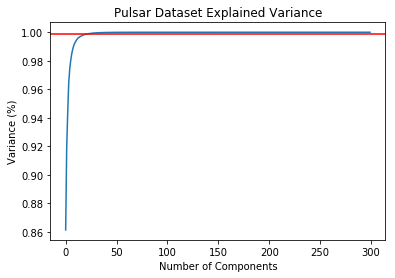

In [243]:
pca = PCA()
pca.fit(scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.axhline(y=0.999, color='r', linestyle='-')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [244]:
pca_scaled = pca.transform(scaled)
pca_scaled.shape

(738, 300)

In [251]:
pca_scaled

array([[ 2.39412782e-01, -1.01090480e+00,  2.17465836e-01, ...,
        -8.62884854e-06, -4.67714716e-06, -7.01886972e-06],
       [ 1.20292492e-01, -9.50110144e-01,  1.85582062e-01, ...,
         2.85388056e-05,  1.81333116e-05, -8.61533500e-06],
       [ 2.36892696e-01, -1.12194483e+00,  1.88146537e-01, ...,
         1.68563911e-05,  8.49959335e-06,  1.82729718e-05],
       ...,
       [ 7.22450654e-02, -2.09100743e-01, -1.55702706e-01, ...,
        -1.10458592e-05,  6.60211223e-06, -1.22569245e-05],
       [ 4.98073799e-02, -1.33493377e-01, -1.84028065e-01, ...,
         1.95429364e-05,  1.31984834e-06,  1.33775898e-06],
       [-1.29258141e+00,  6.19450520e-01, -1.41708987e-02, ...,
         2.43261449e-06, -2.42376745e-06, -4.84249262e-06]])

### Train-test spit

In [245]:
x = pca_scaled
y = df_new['Target']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [246]:
param_grid = [{'min_samples_split':[2, 5, 10, 20, 50]}]

tree_w2v = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
tree_w2v.fit(x_train2, y_train2)

tree_w2v.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 10}

In [247]:
tree_w2v_best = tree_w2v.best_estimator_
print(classification_report(y_test2, tree_w2v_best.predict(x_test2)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       1.00      1.00      1.00         5
           2       0.88      0.88      0.88         8
           3       0.85      1.00      0.92        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       0.96      0.96      0.96        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       0.83      0.83      0.83         6
          10       0.96      0.88      0.92        25
          11       1.00      1.00      1.00         8

   micro avg       0.95      0.95      0.95       148
   macro avg       0.95      0.96      0.95       148
weighted avg       0.95      0.95      0.95       148



### Multinomial NB

In [274]:
from sklearn.naive_bayes import GaussianNB
param_grid = [{"var_smoothing": np.arange(1e-5, 1e-4, 1e-3)}]

# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
mnb_w2v = GridSearchCV(GaussianNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
# fit the gridsearch
mnb_w2v.fit(x_train2, y_train2)
mnb_w2v.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'var_smoothing': 1e-05}

In [276]:
mnb_w2v_best = mnb_w2v.best_estimator_
print(classification_report(y_test2, mnb_w2v_best.predict(x_test2)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       0.67      1.00      0.80         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      0.96      0.98        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      0.92      0.96        25
          11       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.97      0.99      0.98       148
weighted avg       0.98      0.97      0.98       148



### Random Forest

In [277]:
param_grid = {'n_estimators': [30, 50, 70, 100, 200]}

rfc_w2v = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
rfc_w2v.fit(x_train2, y_train2)

rfc_w2v.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 70}

In [278]:
rfc_w2v_best = rfc_w2v.best_estimator_
print(classification_report(y_test2, rfc_w2v_best.predict(x_test2)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       0.73      1.00      0.84         8
           3       1.00      0.73      0.84        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       0.86      0.96      0.91        26
           7       1.00      1.00      1.00         7
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         6
          10       0.96      0.92      0.94        25
          11       1.00      1.00      1.00         8

   micro avg       0.95      0.95      0.95       148
   macro avg       0.96      0.96      0.95       148
weighted avg       0.95      0.95      0.95       148



### Logistic Regression

In [279]:
param_grid = {'C': [0.01,0.1,1,10,20,50]}

lr_w2v = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
lr_w2v.fit(x_train2, y_train2)

lr_w2v.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 50}

In [280]:
lr_w2v_best = lr_w2v.best_estimator_
print(classification_report(y_test2, lr_w2v_best.predict(x_test2)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00         5
           2       0.67      1.00      0.80         8
           3       1.00      0.82      0.90        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       0.93      0.96      0.94        26
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         6
          10       1.00      0.92      0.96        25
          11       1.00      1.00      1.00         8

   micro avg       0.96      0.96      0.96       148
   macro avg       0.97      0.97      0.97       148
weighted avg       0.97      0.96      0.96       148



### KNN

In [281]:
param_grid = {'n_neighbors': [1,5,10,20]}

knn_w2v = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_w2v.fit(x_train2, y_train2)

knn_w2v.best_params_

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 1}

In [282]:
knn_w2v_best = knn_w2v.best_estimator_
print(classification_report(y_test2, knn_w2v_best.predict(x_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00         5
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00         7
           8       0.90      1.00      0.95         9
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00         8

   micro avg       0.99      0.99      0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148

